# Preprocessing the Durham Evening temperature data

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_72403/421620528.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Read in the list of stations
stations = pd.read_csv('../data/raw/temperature/weather_underground/durham_stations.csv')
print(len(stations))

224


In [4]:
pd.pivot_table(stations, index='qcStatus', values='stationId', aggfunc='count')

,stationId
qcStatus,
-1,29
0,14
1,181


In [5]:
stations = stations[stations['qcStatus'] == 1].get(['stationId']).values.flatten()
print(len(stations))

181


In [8]:
base_path = "../data/raw/temperature/weather_underground/stations/"

# Date range
start_date = '2023-07-01'
end_date = '2023-07-31'

dates = [
    str(i).replace("-", "")[:8]
    for i in pd.date_range(start=start_date, end=end_date, freq="D")
]

In [9]:
df = pd.read_csv(os.path.join(base_path, stations[0], f"{dates[0]}.csv"))

df.head()

,timestamp,humidityAvg,qcStatus,tempAvg,solarRadiationHigh,windSpeedAvg,heatindexAvg,pressureMax,pressureTrend
0,2023-07-01 00:00:21,95.0,1,22.9,NaN,0.0,23.8,1016.76,NaN
1,2023-07-01 00:05:21,95.0,1,22.9,NaN,0.0,23.7,1016.63,NaN
2,2023-07-01 00:10:21,95.0,1,22.9,NaN,0.0,23.7,1016.63,NaN
3,2023-07-01 00:15:21,95.0,1,22.8,NaN,0.0,23.7,1016.66,NaN
4,2023-07-01 00:20:21,95.0,1,22.8,NaN,0.0,23.6,1016.76,NaN


In [10]:
# Iterate through each of the stations, and then iterate
# through all of the dates. Combine all of the files into
# one dataframe
all_data = []
for i, station in enumerate(stations):
    if i % 10 == 0:
        print(i)
    station_data = {}
    station_data['stationId'] = station
    data = pd.DataFrame()
    for date in dates:
        try:
            df = pd.read_csv(
                os.path.join(base_path, station, date + ".csv"),
                index_col='timestamp'
            )
            df["stationId"] = station
            data = pd.concat([data, df])
        except FileNotFoundError:
            pass
        except pd.errors.EmptyDataError:
            pass
    
    station_data['data'] = data
    all_data.append(station_data)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180


In [12]:
summary = []

for i, station in enumerate(all_data):
    # If data is empty, skip
    if station['data'].empty:
        continue
    df = station['data']

    # Add hour column
    df['hour'] = pd.to_datetime(station['data'].index).hour

    stationId = station['stationId']

    # Calculate average 7pm temperature
    eve_avg = df[df['hour'] == 19]['tempAvg'].mean()
    eve_na = df[df['hour'] == 19]['tempAvg'].isna().sum()

    if eve_na > 0:
        continue

    # Calculate summary temperature
    summary.append([stationId, eve_avg])

summary = pd.DataFrame(summary, columns=['stationId', 'eve_avg'])
print(len(summary))

121


In [14]:
summary['eve_avg'].values

array([27.94354839, 27.69865591, 28.85107527, 29.15521978, 28.38733154,
       28.02123656, 27.92419355, 28.61236559, 28.5655914 , 28.54701087,
       28.26424731, 28.39555556, 28.20564516, 29.77235772, 28.82634409,
       27.65134409, 29.48714734, 29.24462366, 29.12486339, 29.70666667,
       28.97115903, 28.70026882, 27.48602151, 28.38274933, 30.10188172,
       28.70994624, 29.04327957, 28.2405914 , 28.20053763, 28.38252688,
       27.81505376, 29.05833333, 28.81428571, 29.08408408, 28.1097035 ,
       28.06765499, 28.91639344, 27.52463343, 28.34623656, 28.26935484,
       31.32741935, 28.54247312, 29.2311828 , 29.39018987, 28.65916667,
       27.85      , 28.0983871 , 29.03091398, 27.68459459, 29.95218579,
       29.45564516, 29.69784946, 27.47446237, 28.26846361, 28.69327957,
       26.89623656, 28.69623656, 28.44516129, 28.71142061, 30.5924581 ,
       28.02069892, 27.36370968, 28.36370968, 27.80655271, 27.85430108,
       27.55215054, 28.63709677, 28.25876011, 27.70166667, 28.75

In [24]:
# Save summary data into a dataframe
summary.to_csv('../data/raw/temperature/weather_underground/july23_wu_durham.csv', index=False)

In [16]:
len(summary)

121

So, there are 121 validated weather stations to work with for this analysis.

In [19]:
import pandas as pd
import geopandas as gpd

df = pd.read_csv('../data/raw/temperature/weather_underground/durham_stations.csv')

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)
gdf.set_index('stationId', inplace=True)

In [20]:
gdf.to_crs(epsg=3857, inplace=True)

In [21]:
summary.set_index('stationId', inplace=True)
# Join the summary dataframe with the GDF dataframe
summary2 = summary.join(gdf)
assert len(summary) == len(summary2)

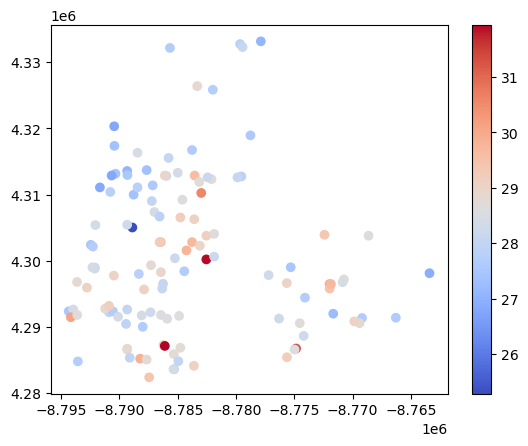

In [22]:
plt.scatter(summary2.geometry.values.x, summary2.geometry.values.y, c=summary2.eve_avg, cmap='coolwarm')
plt.colorbar()
plt.show()

In [23]:
coords = np.vstack([summary2.geometry.values.x, summary2.geometry.values.y]).T
values = summary2.eve_avg.values

# Remove the nan values
coords = coords[~np.isnan(values)]
values = values[~np.isnan(values)]
assert len(coords) == len(values)

values

array([27.94354839, 27.69865591, 28.85107527, 29.15521978, 28.38733154,
       28.02123656, 27.92419355, 28.61236559, 28.5655914 , 28.54701087,
       28.26424731, 28.39555556, 28.20564516, 29.77235772, 28.82634409,
       27.65134409, 29.48714734, 29.24462366, 29.12486339, 29.70666667,
       28.97115903, 28.70026882, 27.48602151, 28.38274933, 30.10188172,
       28.70994624, 29.04327957, 28.2405914 , 28.20053763, 28.38252688,
       27.81505376, 29.05833333, 28.81428571, 29.08408408, 28.1097035 ,
       28.06765499, 28.91639344, 27.52463343, 28.34623656, 28.26935484,
       31.32741935, 28.54247312, 29.2311828 , 29.39018987, 28.65916667,
       27.85      , 28.0983871 , 29.03091398, 27.68459459, 29.95218579,
       29.45564516, 29.69784946, 27.47446237, 28.26846361, 28.69327957,
       26.89623656, 28.69623656, 28.44516129, 28.71142061, 30.5924581 ,
       28.02069892, 27.36370968, 28.36370968, 27.80655271, 27.85430108,
       27.55215054, 28.63709677, 28.25876011, 27.70166667, 28.75

In [108]:
import skgstat as skg

In [160]:
V = skg.Variogram(coords, values, n_lags=10, maxlag=10000, model='exponential', use_nugget=True)#, bin_func='sturges')

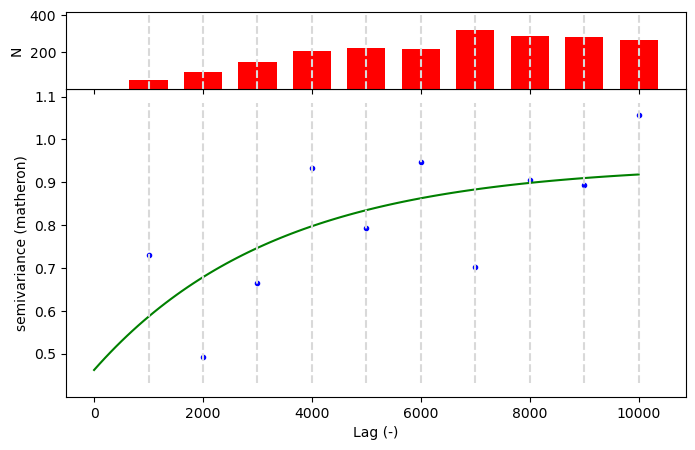

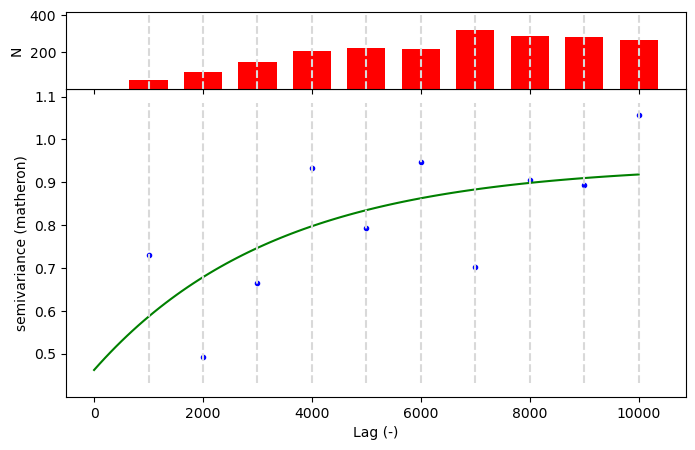

In [161]:
V.plot()

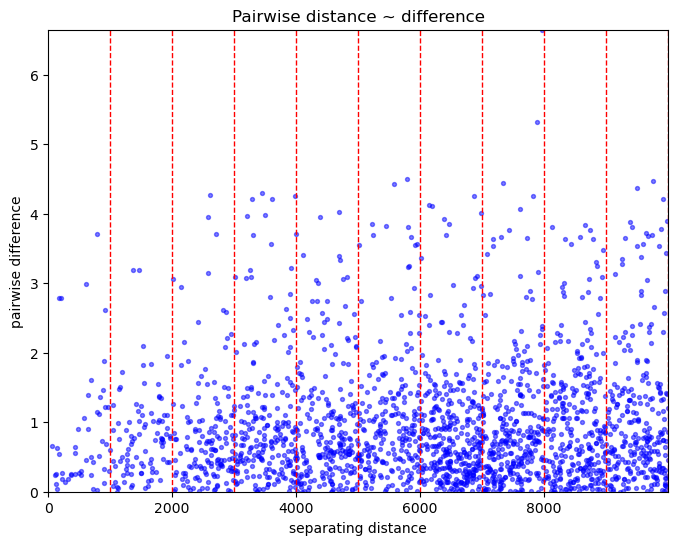

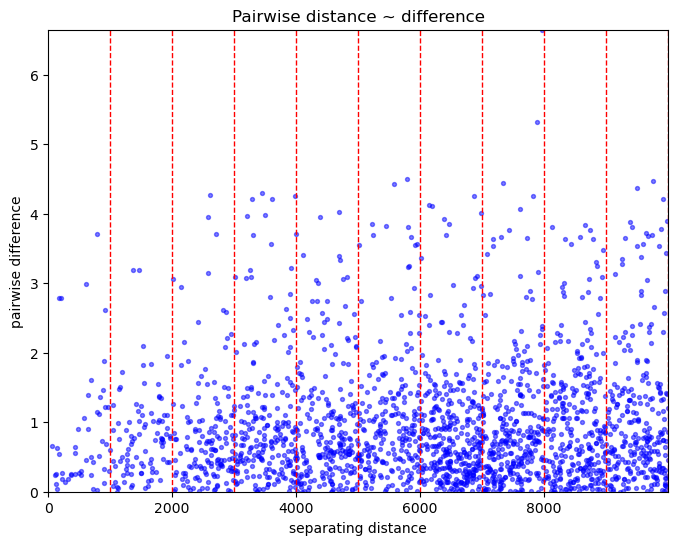

In [162]:
V.distance_difference_plot()

(array([ 1.,  0.,  7., 30., 34., 34.,  9.,  3.,  0.,  3.]),
 array([25.275 , 25.9425, 26.61  , 27.2775, 27.945 , 28.6125, 29.28  ,
        29.9475, 30.615 , 31.2825, 31.95  ]),
 <BarContainer object of 10 artists>)

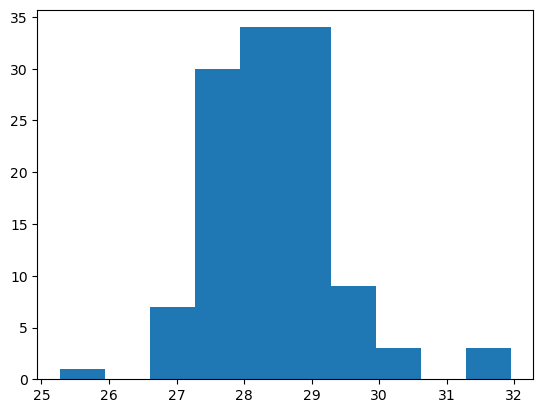

In [25]:
plt.hist(values, bins=10)

All this demonstrates is that it is very hard to fit a variogram to this data, without adding in covariates that can at the very least explain some of the variance. Without explaining some of the variance, there is too much noise in the spatial distribution of the data to glean any real insight from this at all.